# 1. Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline 

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools 

from keras.utils.np_utils import to_categorical #convert to one-hot-encoding 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style = 'white', context= 'notebook', palette = 'deep' )

Using TensorFlow backend.


# 2. Data Preparation 

### 2.1 Load Data

/Users/yooseung/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

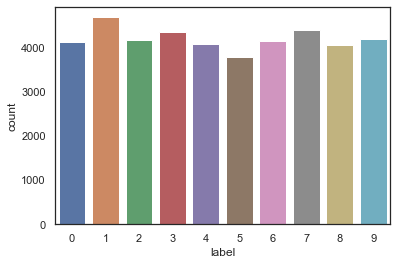

In [2]:
train = pd.read_csv("./input/Lecture 4/train.csv")
test = pd.read_csv("./input/Lecture 4/test.csv")

Y_train = train['label']
X_train = train.drop(labels = ['label'], axis = 1) 

del train # free some space 

g = sns.countplot(Y_train)

Y_train.value_counts() # number of label in Y_train 

### 2.2 Check for null and missing values

* No missing values

In [3]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [4]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 2.3 Normalization 

In [5]:
X_train = X_train / 255.0
test = test / 255.0

# [0, 255] -> [0,1]

### 2.4 Reshape

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
# 28 x 28 x 1 : 3D matirx

# for gray scale -> 28 x 28 x 1
# for RGB image -> 28 x 28 x 3 

### 2.5 Label Encoding

In [7]:
Y_train = to_categorical(Y_train, num_classes = 10)
# one - hot vectors

### 2.6 Split training and Validation set

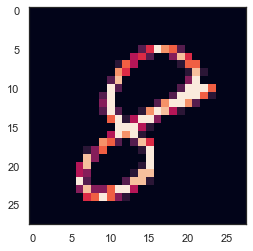

In [8]:
random_seed = 2 #random seed 

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size = 0.1, 
                                                  random_state = random_seed)

# use stratify = True option in train_test_split to avoid unbalanced dataset

#example
g = plt.imshow(X_train[0][:, :, 0])

# 3. CNN

### 3.1 Define the model 

* convolutional layers : transforms the image 
    - 32 filters for first two 
    - 64 filters for last two 

* pooling layer : down sampling 
    - reduce computational cost
    - reduce overfitting 
    
* Dropout : regularization method 
    - ignore some proportion of nodes 
    - reduce overfitting 
    
* Rectifier: we use ReLU
    - max(0,x)
    - add non-linearity to the network
    
* Flatten Layer: 
    - final feature map to 1D vector 
    
* Dense Layer: fully connected layers 
    - ANN classifier
    - last layer outputs the distribution of probability 
 

In [9]:
# In -> [Conv2D -> relu] * 2 ->  [ MaxPool2D ->  Dropout ] * 2 -> Flatten -> Dense -> Droupout -> Out

model = Sequential() 
model.add(Conv2D(filters = 32 , 
                 kernel_size = (5,5) , 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (28,28,1)))

model.add(Conv2D(filters = 32 , 
                 kernel_size = (5,5) , 
                 padding = 'Same',
                 activation = 'relu'))

model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3),
                 padding = 'Same', 
                 activation = 'relu'))

model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3),
                 padding = 'Same', 
                 activation = 'relu'))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))

model.add(Dropout(0.5))

model.add(Dense(10, activation = 'softmax'))


2021-11-02 17:51:29.848882: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 17:51:29.849862: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


### 3.2 Set the optimizer and annealer 

* loss function = categorical crossentropy
* optimizer: iteratively improve parameters (minimize the loss) 
* RMSprop : Adagrad method 
* Decreasing LR : if the accuracy is not improved

In [28]:
optimizer = RMSprop() # good to leave its default value (lr = 0.001, rho = 0.9)

model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

epochs = 10

batch_size = 86

### 3.3 Data Augmentation 

* Artificially expand the dataset
    - rotating
    - big or small writing
    - not centered
    - horizontal or vertical flip
    - crop...
    
* Increase the number of the datasets 

In [29]:
datagen = ImageDataGenerator(
    featurewise_center = False, #set input mean = 0
    samplewise_center = False,
    featurewise_std_normalization = False, # divide each input by its std
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10,#rotate 10 degrees 
    zoom_range = 0.1,
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    horizontal_flip = False, # DO NOT flip images 
    vertical_flip = False)

datagen.fit(X_train) 

#fitting 
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                              epochs = epochs,
                              validation_data = (X_val, Y_val),
                              verbose = 1, # 0: silence 1: progress, 2: per line 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks = [learning_rate_reduction])

Epoch 1/10
439/439 [==============================] - 487s 1s/step - loss: 0.1223 - accuracy: 0.9631 - val_loss: 0.0414 - val_accuracy: 0.9881
Epoch 2/10


/Users/yooseung/opt/anaconda3/envs/tf/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


439/439 [==============================] - 488s 1s/step - loss: 0.0922 - accuracy: 0.9725 - val_loss: 0.0525 - val_accuracy: 0.9855
Epoch 3/10
439/439 [==============================] - 1725s 4s/step - loss: 0.0777 - accuracy: 0.9766 - val_loss: 0.0319 - val_accuracy: 0.9907
Epoch 4/10
439/439 [==============================] - 482s 1s/step - loss: 0.0735 - accuracy: 0.9794 - val_loss: 0.0401 - val_accuracy: 0.9881
Epoch 5/10
439/439 [==============================] - 482s 1s/step - loss: 0.0651 - accuracy: 0.9811 - val_loss: 0.0278 - val_accuracy: 0.9917
Epoch 6/10
439/439 [==============================] - 1158s 3s/step - loss: 0.0661 - accuracy: 0.9808 - val_loss: 0.0477 - val_accuracy: 0.9876
Epoch 7/10
439/439 [==============================] - 487s 1s/step - loss: 0.0710 - accuracy: 0.9814 - val_loss: 0.0453 - val_accuracy: 0.9905
Epoch 8/10
439/439 [==============================] - 497s 1s/step - loss: 0.0688 - accuracy: 0.9819 - val_loss: 0.0301 - val_accuracy: 0.9924
Epoch 9/

# 4. Evalutate the model

### 4.1 Training and validation curves 

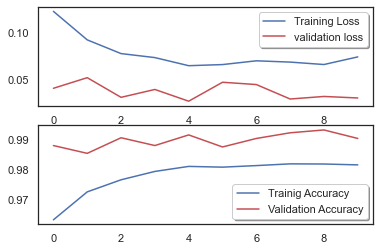

In [30]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'],
           color =  'b', 
           label = 'Training Loss')
ax[0].plot(history.history['val_loss'], 
           color = 'r',
           label = 'validation loss',
           axes = ax[0])
legend = ax[0].legend(loc = 'best' , shadow = True) 

ax[1].plot(history.history['accuracy'], 
           color = 'b', 
           label = 'Trainig Accuracy')

ax[1].plot(history.history['val_accuracy'],
           color = 'r', 
           label = 'Validation Accuracy')
legend = ax[1].legend(loc = 'best', shadow = True) 

### 4.2 Confusion Matrix
* Helpful to see drawbacks

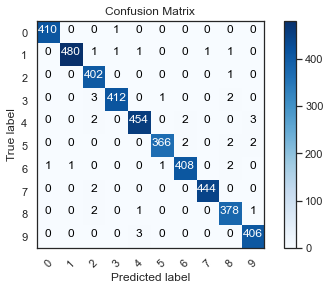

In [32]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    
    #product of cm[0] and cm[1]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment = 'center',
                color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(10))

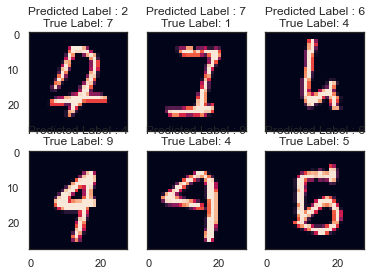

In [67]:
errors = Y_pred_classes - Y_true != 0
Y_pred_classes_errors = Y_pred_classes[errors] #only false ones
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape(28,28)) #make to 2D image
            ax[row, col].set_title("Predicted Label : {}\nTrue Label: {}".format(
                pred_errors[error], obs_errors[error]))
            n += 1

# prob of the wrong predicted numbers 

Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1) 
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [69]:
results = model.predict(test)

results = np.argmax(results, axis = 1) # indices of max values 

results = pd.Series(results, name = 'Label')

submission = pd.concat([pd.Series(range(1,28001), name = 'ImageID'), results], axis = 1)

submission.to_csv("cnn_mnist_datagen.csv", index = False)